In [1]:
import re
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
# Reads one block of the file, used in mdm_reader
def read_block(body):
    lines = body.strip().split("\n")
    output = StringIO()
    info=[]
    for line in lines:
        tline= line.strip()
        if tline.startswith("ICCAP_VAR") or tline.startswith("#"):
            info.append(tline)
            new_line = "%"+ tline
        else:
            
            new_line = tline
        # only write non blank lines
        if (new_line):
            output.write(new_line + '\n')
    output.seek(0)
    data = np.loadtxt(output, comments='%')
    return data,info

# Reads only a precise measurement of a file (to chose one specific Vg for instance)
# measurement_index is the place of occurence in the file
def mdm_reader_index(fname,measurement_index):
    f = open(fname, "r")    
    text = f.read()
    ldata = []
    i=0
    for begin_match, end_match in zip(re.finditer("BEGIN_DB", text), re.finditer("END_DB", text)):
        
        s = begin_match.end()
        e = end_match.start()
        body = text[s:e]
        
        if i==measurement_index:
            data,info = read_block(body)
            ldata.append(data)
        i+=1
        # convert to numpy array
    adata = np.array(ldata)
    f.close()
    return adata,info

# Reads a whole file
def mdm_reader_extract(fname):
    f = open(fname, "r")    
    text = f.read()
    ldata = []
    i=0
    for begin_match, end_match in zip(re.finditer("BEGIN_DB", text), re.finditer("END_DB", text)):
        
        s = begin_match.end()
        e = end_match.start()
        body = text[s:e]
        
       
        data,info = read_block(body)
        ldata.append(data)
        
        # convert to numpy array
    adata = np.array(ldata)
    f.close()
    return adata

### Id Vd curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


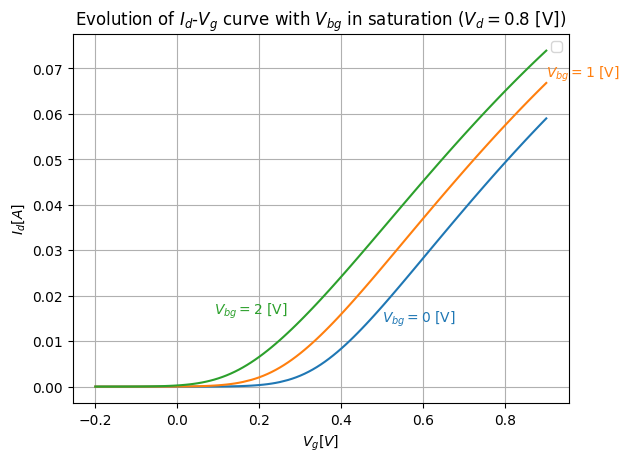

In [3]:
# SLVT stands for super low threshold voltage
# File format : Die - Type - Finger Width - Number of fingers - Vbg - IV measured - Reference voltage (Vd if Vg in IV curve and vice versa)

vbg0 = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_idvg_sat_800m.mdm"
vbg1 = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_1V_idvg_sat_800m.mdm"
vbg2 = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_2V_idvg_sat_800m.mdm"

# vref should be either 'Vg' or 'Vd'                                               
def IVcurve(file, measurement_index, v_index, i_index, vref, xlabel='V', ylabel='I', title='IV Curve',plot=False):
    data, info = mdm_reader_index(file, measurement_index)
    data = data[0]

    v_ref = float(info[0].split()[-1])
    v = [column[v_index] for column in data]
    i = [column[i_index] for column in data]

    # Plot
    if plot:
        plt.plot(v, i, linestyle='-')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plotTitle = title + ", {} = {}".format(vref, v_ref)
        plt.title(plotTitle)
        plt.grid(True)
    #plt.show()

    # Return
    return v, i



vg0, id0 = IVcurve(vbg0, 0, 0, 1, '$V_d$', '$V_g$', '$I_d$', '$I_d$ vs $V_g$')
vg1, id1 = IVcurve(vbg1, 0, 0, 1, '$V_d$', '$V_g$', '$I_d$', '$I_d$ vs $V_g$')
vg2, id2 = IVcurve(vbg2, 0, 0, 1, '$V_d$', '$V_g$', '$I_d$', '$I_d$ vs $V_g$')

line0, = plt.plot(vg0, id0, linestyle='-', label=None)
line1, = plt.plot(vg1, id1, linestyle='-', label=None)
line2, = plt.plot(vg2, id2, linestyle='-', label=None)

plt.text(vg0[70], id0[65], "$V_{bg}=0$ [V]", color=line0.get_color(), verticalalignment='bottom', horizontalalignment='left')
plt.text(vg1[-1], id1[-1], "$V_{bg}=1$ [V]", color=line1.get_color(), verticalalignment='bottom', horizontalalignment='left')
plt.text(vg2[47], id2[50], "$V_{bg}=2$ [V]", color=line2.get_color(), verticalalignment='bottom', horizontalalignment='right')

plt.xlabel("$V_g [V] $")
plt.ylabel("$I_d [A]$")
plotTitle = "Evolution of $I_d$-$V_g$ curve with $V_{bg}$ in saturation ($V_d=0.8$ [V])"
plt.title(plotTitle)
plt.grid(True)
plt.legend()
plt.savefig("Id-Vg-background.pdf")
plt.show()

## Extract Vth (plot cf slide 8 cours analog perf of mos transistor denis, peut etre interessant pour le power point)


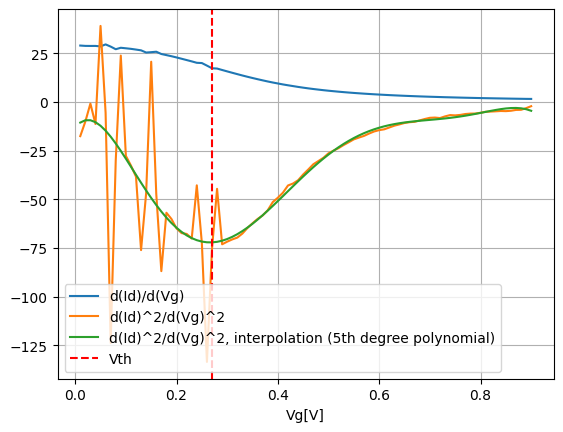

Vth= 0.27


In [4]:
### Pourquoi pas ln ??
Vth_file="../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_idvg_sat_800m.mdm"
def extract_vth( file_name,measurement_index, id_index , vg_index,plot=False):
    data,info=mdm_reader_index(file_name,measurement_index)
    measurement=data[0]
    
   
    vd= info[0].split()[-1]
   
    vg = np.array([column[vg_index] for column in measurement])
    id = np.array([column[id_index] for column in measurement])

    id = id[vg > 0]
    vg = vg[vg > 0]
    
    deriv_1=np.gradient(np.log(id),0.01)
    
    deriv_2=np.gradient(deriv_1,0.01)
    indice_max=np.argmax(deriv_2)

    coefs = np.polyfit(vg, deriv_2, 6)
    interp = np.poly1d(coefs)
    polynomial_interp = interp(vg)

    indice_min = np.argmin(polynomial_interp)

    if plot==True:
    
        plt.plot(vg, deriv_1 , linestyle='-',label="d(Id)/d(Vg)")
        plt.plot(vg, deriv_2 , linestyle='-',label="d(Id)^2/d(Vg)^2")
        plt.plot(vg, polynomial_interp, linestyle='-',label="d(Id)^2/d(Vg)^2, interpolation (5th degree polynomial)")
        plt.xlabel('Vg[V]')
      
        plt.axvline(x=vg[indice_min], color='r', linestyle='--',label="Vth")
        plt.grid(True)
        plt.legend(loc='best')
        plt.show()
    
    # return vg[indice_max]
    return vg[indice_min]


Vth=extract_vth( Vth_file,0, 1 , 0,True)
print("Vth=",Vth)


## Plot Vth-Vbg

la pente est: -0.08000000000000002


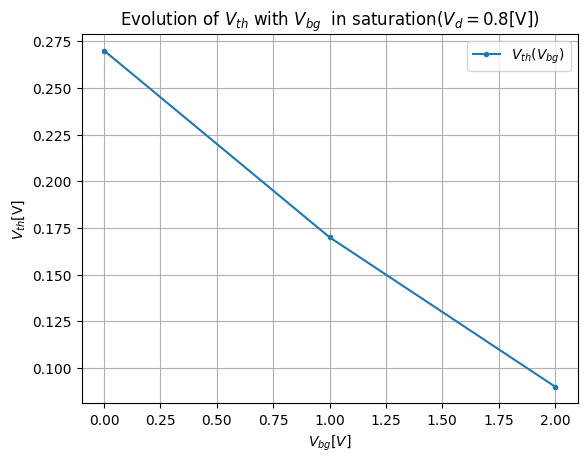

In [5]:

Vth0=extract_vth( vbg0,0, 1 , 0,False)
Vth1=extract_vth( vbg1,0, 1 , 0,False)
Vth2=extract_vth( vbg2,0, 1 , 0,False)

Vbg_vec=[0,1,2]
Vth_vec=[Vth0,Vth1,Vth2]
print("la pente est:", (Vth2-Vth1)/(1))
plt.plot(Vbg_vec, Vth_vec,".-",label="$V_{th}(V_{bg})$")

plt.xlabel('$V_{bg}[V]$')
plt.ylabel("$V_{th}$[V]")
plt.title("Evolution of $V_{th}$ with $V_{bg}$  in saturation($V_d=0.8$[V])")
plt.grid(True)
plt.legend(loc='best')
plt.savefig("VthVbg.pdf")
plt.savefig("VthVbg.png")
plt.show()


### S Parameters

In [6]:
file2 = '../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_Spar_HF_cold_0V.mdm'

def S_parameters(file, measurement_index, norm=True, plot=False):
    data, info = mdm_reader_index(file, measurement_index)
    data = data[0]

    vd = info[0].split()[-1]
    vg = info[1].split()[-1]
    f = data[:, 0]
    # c for complex
    S11c = np.array([data[:, 3], data[:, 4]])
    S12c = np.array([data[:, 5], data[:, 6]])
    S21c = np.array([data[:, 7], data[:, 8]])
    S22c = np.array([data[:, 9], data[:, 10]])

    S11 = 20*np.log10(np.sqrt(S11c[0]**2 + S11c[1]**2))
    S12 = 20*np.log10(np.sqrt(S12c[0]**2 + S12c[1]**2))
    S21 = 20*np.log10(np.sqrt(S21c[0]**2 + S21c[1]**2))
    S22 = 20*np.log10(np.sqrt(S22c[0]**2 + S22c[1]**2))

    if plot:
        plt.plot(f*1e-9, S11, linestyle='-', label='S11')
        plt.plot(f*1e-9, S12, linestyle='-', label='S12')
        plt.plot(f*1e-9, S21, linestyle='-', label='S21')
        plt.plot(f*1e-9, S22, linestyle='-', label='S22')
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Magnitude [dB]')
        plt.title('S Parameters, Vd = {}, Vg = {}'.format(vd, vg))
        plt.grid(True)
        plt.legend()
        plt.show()
        
    if norm:
        return S11, S12, S21, S22
    else:
        return S11c[0] + 1j*S11c[1], S12c[0] + 1j*S12c[1], S21c[0] + 1j*S21c[1], S22c[0] + 1j*S22c[1]
    
    
S11, S12, S21, S22 = S_parameters(file2, 0, norm=False)

### Y and Z Parameters

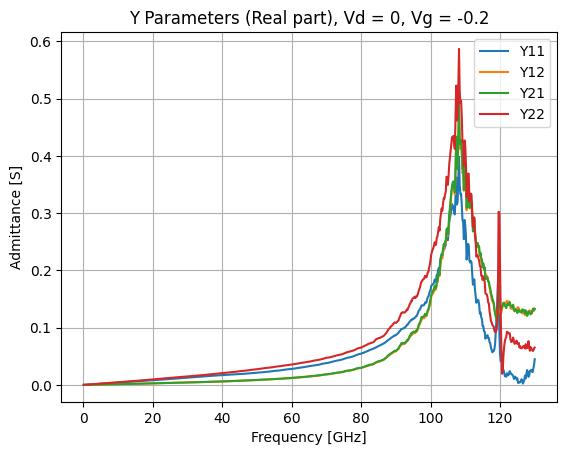

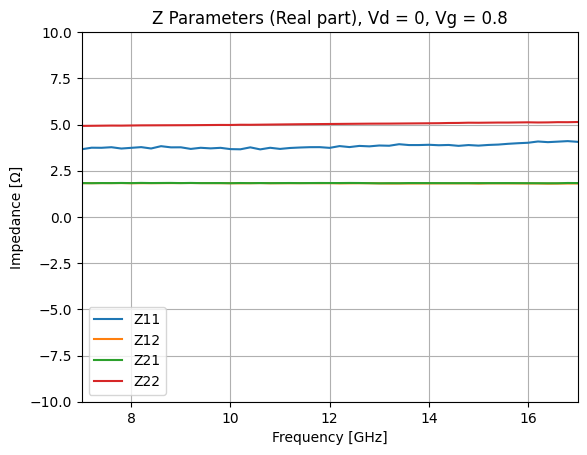

In [7]:
def Y_parameters(file, measurement_index, plot=False):
    data, info = mdm_reader_index(file, measurement_index)
    data = data[0]

    vd = info[0].split()[-1]
    vg = info[1].split()[-1]
    f = data[:, 0]
    # c for complex
    S11c = np.array([data[:, 3], data[:, 4]])
    S12c = np.array([data[:, 5], data[:, 6]])
    S21c = np.array([data[:, 7], data[:, 8]])
    S22c = np.array([data[:, 9], data[:, 10]])

    S11 = S11c[0] + 1j*S11c[1]
    S12 = S12c[0] + 1j*S12c[1]
    S21 = S21c[0] + 1j*S21c[1]
    S22 = S22c[0] + 1j*S22c[1]

    Y11 = ((1 + S22) * (1 - S11) + S12 * S21) / ((1 + S22) * (1 + S11) - S12 * S21)
    Y12 = -2*S12/((1 + S22) * (1 + S11) - S12 * S21)
    Y21 = -2*S21/((1 + S22) * (1 + S11) - S12 * S21)
    Y22 = ((1 + S11) * (1 - S22) + S12 * S21) / ((1 + S22) * (1 + S11) - S12 * S21)

    Y11 /= 50
    Y12 /= 50
    Y21 /= 50
    Y22 /= 50

    if plot:
        # plt.plot(f*1e-9, np.real(Y11), linestyle='-', label='Y11')
        # plt.plot(f*1e-9, np.real(Y12), linestyle='-', label='Y12')
        # plt.plot(f*1e-9, np.real(Y21), linestyle='-', label='Y21')
        # plt.plot(f*1e-9, np.real(Y22), linestyle='-', label='Y22')

        plt.plot(f*1e-9, np.absolute(Y11), linestyle='-', label='Y11')
        plt.plot(f*1e-9, np.absolute(Y12), linestyle='-', label='Y12')
        plt.plot(f*1e-9, np.absolute(Y21), linestyle='-', label='Y21')
        plt.plot(f*1e-9, np.absolute(Y22), linestyle='-', label='Y22')
        
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Admittance [S]')
        plt.title('Y Parameters (Real part), Vd = {}, Vg = {}'.format(vd, vg))
        plt.grid(True)
        plt.legend()
        plt.show()
        
    return Y11, Y12, Y21, Y22

Y11, Y12, Y21, Y22 = Y_parameters(file2, 0, plot=True)


# Scale sucks for this one
def Z_parameters(file, measurement_index, plot=False):
    data, info = mdm_reader_index(file, measurement_index)
    data = data[0]

    vd = info[0].split()[-1]
    vg = info[1].split()[-1]
    f = data[:, 0]
    # c for complex
    S11c = np.array([data[:, 3], data[:, 4]])
    S12c = np.array([data[:, 5], data[:, 6]])
    S21c = np.array([data[:, 7], data[:, 8]])
    S22c = np.array([data[:, 9], data[:, 10]])

    S11 = S11c[0] + 1j*S11c[1]
    S12 = S12c[0] + 1j*S12c[1]
    S21 = S21c[0] + 1j*S21c[1]
    S22 = S22c[0] + 1j*S22c[1]

    Z11 = ((1 + S11) * (1 - S22) + S12 * S21) / ((1 -S11) * (1 - S22) - S12 * S21)
    Z12 = 2*S12/((1 - S11) * (1 -S22) - S12 * S21)
    Z21 = 2*S21/((1 - S11) * (1 -S22) - S12 * S21)
    Z22 = ((1 + S22) * (1 - S11) + S12 * S21) / ((1 -S11) * (1 - S22) - S12 * S21)

    Z11 *= 50
    Z12 *= 50
    Z21 *= 50
    Z22 *= 50

    if plot:
        plt.plot(f*1e-9, np.real(Z11), linestyle='-', label='Z11')
        plt.plot(f*1e-9, np.real(Z12), linestyle='-', label='Z12')
        plt.plot(f*1e-9, np.real(Z21), linestyle='-', label='Z21')
        plt.plot(f*1e-9, np.real(Z22), linestyle='-', label='Z22')

        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Impedance [Ω]')
        plt.ylim(-10, 10)
        plt.xlim(7, 17)
        plt.title('Z Parameters (Real part), Vd = {}, Vg = {}'.format(vd, vg))
        plt.grid(True)
        plt.legend()
        plt.show()
        
    return Z11, Z12, Z21, Z22

Z11, Z12, Z21, Z22 = Z_parameters(file2, 10, plot=True)

## Parameters extraction

Based on Babak Kazemi Esfeh's thesis.

First step is open de-embedding : measured impedance contains that of the device and the series resistance and inductance of the contacts.

    ==> Ztot = (Ymeasured - Yopen)^-1 , and Ztot = Zseries + Zdevice. We can retrieve Zdevice! 
    
    

In [8]:
# Open de-embedding
measurements = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_Spar_HF_cold_0V.mdm"
open_measurements = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_OPEN_Spar_HF.mdm"

def deEmbedding(measurements, open):
    # This function does not retrieve the bias for each index, handle with care!
    # The function returns the 4 z-parameters. Zij[k][l] indicates Zij at bias given by index k and at a frequency given by index l

    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])
    f = data[0][:, 0]

    Y11o, Y12o, Y21o, Y22o = Y_parameters(open, 0) # only one index in the file...
    Y11t, Y12t, Y21t, Y22t = [np.zeros((len_data, len_col), dtype='complex') for _ in range(4)] # o for open, t for total (measured here)
    Y11d, Y12d, Y21d, Y22d = [np.zeros((len_data, len_col), dtype='complex') for _ in range(4)] # d for device (intrinsic AND extrinsic here)

    for i in range(len_data):
        Y11t[i], Y12t[i], Y21t[i], Y22t[i] = Y_parameters(measurements, i, plot=False)
        Y11d[i] = Y11t[i] - Y11o
        Y12d[i] = Y12t[i] - Y12o
        Y21d[i] = Y21t[i] - Y21o
        Y22d[i] = Y22t[i] - Y22o

    
    # Construction of the Z-matrices
    Z11, Z12, Z21, Z22 = [np.zeros_like(Y11d) for _ in range(4)]
    for i in range(len_data):
        for j in range(len_col):
            Y = np.array([[Y11d[i][j], Y12d[i][j]], [Y21d[i][j], Y22d[i][j]]])
            Z = np.linalg.inv(Y)
            Z11[i][j], Z12[i][j], Z21[i][j], Z22[i][j] = np.matrix.flatten(Z)

    return Z11, Z12, Z21, Z22

Z11, Z12, Z21, Z22 = deEmbedding(measurements, open_measurements)

Now that we have a function to de-embedded the device, we can use it and extract the extrinsic parameters. 

/!\ Only the values for Vg >> Vth are meaningful, so be careful with that

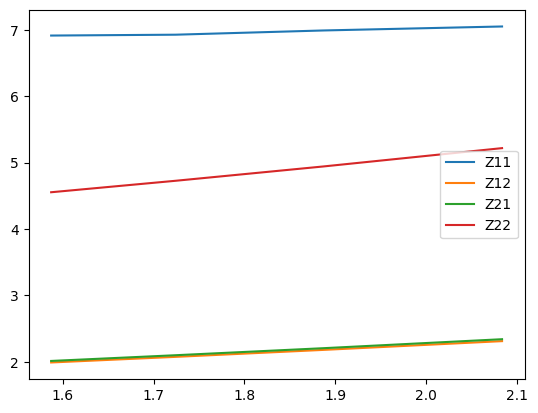

0.9588052561289429
5.519524199864615
1.4677254203303574
1.851163942265134e-14
9.258473466222264e-15
1.521646791119446e-14


In [9]:
def extrinsic_parameters(measurements, open, Vth, plot=False):
    # Since we have to average the S-parameters on a range of around 10GHz, we will choose arbitrarily (not too high in freq though)
    
    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])

    freq = data[0][:, 0]
    deltaf = (freq[1]-freq[0])*1e-9
    numfreq = int(10/deltaf)    # We want a range of 10GHz
    start_index = 34   # We start at 7GHz
    # start_index = numfreq

    # For the resistances, we only work with a slice of the frequencies (10GHz band)
    freq_slice = freq[start_index:start_index+numfreq]

    # print(freq_slice[0])
    # print(freq_slice[-1])

    Vg = np.zeros(len_data)

    Z11, Z12, Z21, Z22 = deEmbedding(measurements, open)

    Z11_mean, Z12_mean, Z21_mean, Z22_mean = [np.zeros(len_data, dtype='complex') for _ in range(4)]
    
    # we iterate on each bias point
    for i in range(len_data):
        Z11_mean[i] = np.mean(Z11[i][start_index:start_index+numfreq])
        Z12_mean[i] = np.mean(Z12[i][start_index:start_index+numfreq])
        Z21_mean[i] = np.mean(Z21[i][start_index:start_index+numfreq])
        Z22_mean[i] = np.mean(Z22[i][start_index:start_index+numfreq])
        
        dummy, info = mdm_reader_index(measurements, i)
        Vg[i] = float(info[1].split()[-1])
    
    # We only keep the last 4 indices
    Vg = Vg[-4:]
    Z11_mean = Z11_mean[-4:]
    Z12_mean = Z12_mean[-4:]
    Z21_mean = Z21_mean[-4:]
    Z22_mean = Z22_mean[-4:]

    if plot:
        plt.plot(1/(Vg-Vth), np.real(Z11_mean), label='Z11') # Ajouter points de mesure
        plt.plot(1/(Vg-Vth), np.real(Z12_mean), label='Z12')
        plt.plot(1/(Vg-Vth), np.real(Z21_mean), label='Z21')
        plt.plot(1/(Vg-Vth), np.real(Z22_mean), label='Z22')

        plt.legend()
        plt.show()

    # Extrapolation the curves at 0 (only the real part, to find resistances)

    # First order approx, because effective mobility also varies on Vg, so gds actually depends on 1/(Vg-Vth) * 1/mu
    dzdv11 = (np.real(Z11_mean[-1]) - np.real(Z11_mean[0])) / (1/(Vg[-1]-Vth) - 1/(Vg[0]-Vth))
    dzdv12 = (np.real(Z12_mean[-1]) - np.real(Z12_mean[0])) / (1/(Vg[-1]-Vth) - 1/(Vg[0]-Vth))
    dzdv21 = (np.real(Z21_mean[-1]) - np.real(Z21_mean[0])) / (1/(Vg[-1]-Vth) - 1/(Vg[0]-Vth))
    dzdv22 = (np.real(Z22_mean[-1]) - np.real(Z22_mean[0])) / (1/(Vg[-1]-Vth) - 1/(Vg[0]-Vth))    

    Z11_interp = np.real(Z11_mean[0]) - dzdv11 * 1/(Vg[0]-Vth)
    Z12_interp = np.real(Z12_mean[0]) - dzdv12 * 1/(Vg[0]-Vth)
    Z21_interp = np.real(Z21_mean[0]) - dzdv21 * 1/(Vg[0]-Vth)
    Z22_interp = np.real(Z22_mean[0]) - dzdv22 * 1/(Vg[0]-Vth)

    # System of equation
    Rse = Z12_interp
    Rge = Z11_interp - Rse
    Rde = Z22_interp - Rse


    # Extraction of the capacitances at Vg < 0 (deep depletion)
    # We start by retrieving the Z-matrix of the device by substracting the Zseries-matrix (Zinterp)
    for i in range(len_data):
        Z11 -= Z11_interp
        Z12 -= Z12_interp
        Z21 -= Z21_interp
        Z22 -= Z22_interp

    Y11, Y12, Y21, Y22 = [np.zeros_like(Z11) for _ in range(4)]
    for i in range(len_data):
        for j in range(len_col):
            Y = np.linalg.inv(np.array([[Z11[i][j], Z12[i][j]], [Z21[i][j], Z22[i][j]]]))
            Y11[i][j], Y12[i][j], Y21[i][j], Y22[i][j] = np.matrix.flatten(Y)
    
    # Only Y[0] interests us because we want Vg < 0. dd for deep depletion
    # We need to work at a specific frequency ! 
    working_freq_idx = 59  # We are working at 12GHz 

    Y11dd = Y11[0][working_freq_idx]
    Y12dd = Y12[0][working_freq_idx]
    Y21dd = Y21[0][working_freq_idx]
    Y22dd = Y22[0][working_freq_idx]

    f_capa = freq[working_freq_idx]
    w_capa = 2*np.pi*f_capa

    Cgse = np.imag(Y11dd+Y12dd) / w_capa
    Cdse = np.imag(Y22dd+Y12dd) / w_capa
    Cgde = -np.imag(Y12dd) / w_capa

    return Rse, Rge, Rde, Cgse, Cdse, Cgde 


Rse, Rge, Rde, Cgse, Cdse, Cgde = extrinsic_parameters(measurements, open_measurements, 0.27, plot=True)

print(Rse)
print(Rge)
print(Rde)
print(Cgse)
print(Cdse)
print(Cgde)

### Extraction of intrinsic parameters

In [10]:
file = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_Spar_HF_sat_0p8.mdm"


def intrinsic_parameters(measurements, open, Vth, Rse=0, Rge=0, Rde=0, Cgse=0, Cdse=0, Cgde=0, plot=False):

    # Retrieving the parameters
    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])
    freq = data[0][:, 0]


    # Construction of the series matrix:
    Z_series = np.array([[Rge+Rse, Rse], [Rse, Rde+Rse]])

    Vg = np.zeros(len_data)
    Vd = np.zeros(len_data)

    Z11, Z12, Z21, Z22 = deEmbedding(measurements, open)

    # We iterate on each bias point to get Vg and Vd
    for i in range(len_data):
        dummy, info = mdm_reader_index(measurements, i)
        Vg[i] = float(info[1].split()[-1])
        Vd[i] = float(info[0].split()[-1])
        
    # Retrieve series matrix from total Z matrix to get DUT Z-matrix
    Z11 -= Z_series[0,0]
    Z12 -= Z_series[0,1]
    Z21 -= Z_series[1,0]
    Z22 -= Z_series[1,1]

    # Get admittance matrix from impedance matrix
    Y11, Y12, Y21, Y22 = [np.zeros_like(Z11) for _ in range(4)]
    for i in range(len_data):
        for j in range(len_col):
            Y = np.linalg.inv(np.array([[Z11[i][j], Z12[i][j]], [Z21[i][j], Z22[i][j]]]))
            Y11[i][j], Y12[i][j], Y21[i][j], Y22[i][j] = np.matrix.flatten(Y)

    # We select a high Vg to be in strong inversion:


    freq_index = 59   # 20.2 GHz
    Y11_inv = Y11[:,freq_index]
    Y12_inv = Y12[:,freq_index]
    Y21_inv = Y21[:,freq_index]
    Y22_inv = Y22[:,freq_index]

    Cgs = np.imag(Y11_inv+Y12_inv) / (2*np.pi*freq[freq_index])
    Cds = np.imag(Y22_inv+Y12_inv) / (2*np.pi*freq[freq_index])
    Cgd = -np.imag(Y12_inv) / (2*np.pi*freq[freq_index])
    gm = np.abs(Y21_inv-Y12_inv)
    gds = np.real(Y22_inv)
    tau = -1*np.angle(Y21_inv-Y12_inv)

    print("Parameters extracted at {:.2f} GHz  and Vd={}V".format(freq[freq_index]*1e-9, Vd[-6]))
    return Cgs, Cds, Cgd, gm, gds, tau,Vg

Cgs, Cds, Cgd, gm, gds, tau,Vg = intrinsic_parameters(file, open_measurements, 0.27, Rse, Rge, Rde, Cgse, Cdse, Cgde)
Vg_indice=list(Vg).index(0.6)

# print("Cgs:,",Cgs[Vg_indice])
# print("Cds:,",Cds[Vg_indice])
# print("Cgd:,",Cgd[Vg_indice])
# print("gm:,",gm[Vg_indice])
# print("gds,",gds[Vg_indice])
# print("Vg:",Vg[Vg_indice])




Parameters extracted at 12.00 GHz  and Vd=0.8V


In [11]:
def FoM(Cgs, Cds, Cgd, Rs, Rd, Rg, gm, gds):
    # den_ft = 2*np.pi*Cgs*(1+Cgd/Cgs)+(Rs+Rd)*((gm+gds)*Cgd/Cgs+gds)  # PQ CETTE FORMULE MARCHE PAS????????????
    # ft = gm/den_ft
    ft = gm/(2*np.pi*(Cgs+Cgd))

    den_fmax = 4*np.pi*Cgs*(1+Cgd/Cgs)*np.sqrt(gds*(Rs+Rg)+0.5*(Cgd/Cgs)*(Rs*gm+Cgd/Cgs))
    fmax = ft/(2*(np.sqrt((Rs+Rg)*gds+2*np.pi*ft*Rg*Cgd)))
    
    return ft, fmax

ft, fmax = FoM(Cgs, Cds, Cgd, Rse, Rde, Rge, gm, gds)

# print(ft*1e-9)
# print(fmax*1e-9)

## Plot Ft for different Vbg


In [12]:
Vbg0 = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_Spar_HF_sat_0p8.mdm"
Vbg1 = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_1V_Spar_HF_sat_0p8.mdm"
Vbg2 = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_2V_Spar_HF_sat_0p8.mdm"
Cgs0, Cds0, Cgd0, gm0, gds0, tau0,Vg = intrinsic_parameters(Vbg0, open_measurements, 0.33, Rse, Rge, Rde, Cgse, Cdse, Cgde)
ft0, fmax0 = FoM(Cgs0, Cds0, Cgd0, Rse, Rde, Rge, gm0, gds0)
Cgs1, Cds1, Cgd1, gm1, gds1, tau1,Vg1 = intrinsic_parameters(Vbg1, open_measurements, 0.33, Rse, Rge, Rde, Cgse, Cdse, Cgde)
ft1, fmax1 = FoM(Cgs1, Cds1, Cgd1, Rse, Rde, Rge, gm1, gds1)
Cgs2, Cds2, Cgd2, gm2, gds2, tau2,Vg2 = intrinsic_parameters(Vbg2, open_measurements, 0.33, Rse, Rge, Rde, Cgse, Cdse, Cgde)
ft2, fmax2 = FoM(Cgs2, Cds2, Cgd2, Rse, Rde, Rge, gm2, gds2)


Parameters extracted at 12.00 GHz  and Vd=0.8V
Parameters extracted at 12.00 GHz  and Vd=0.8V
Parameters extracted at 12.00 GHz  and Vd=0.8V


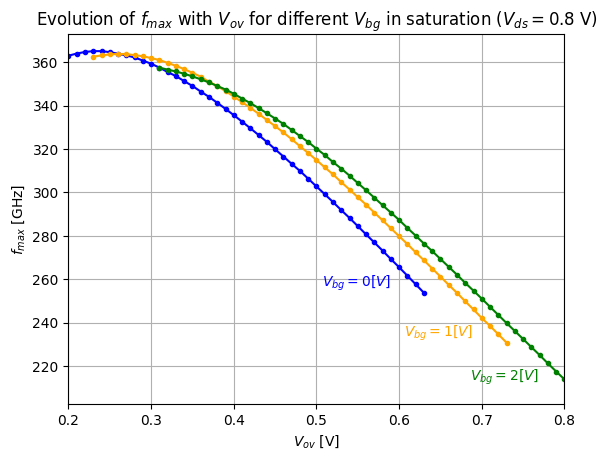

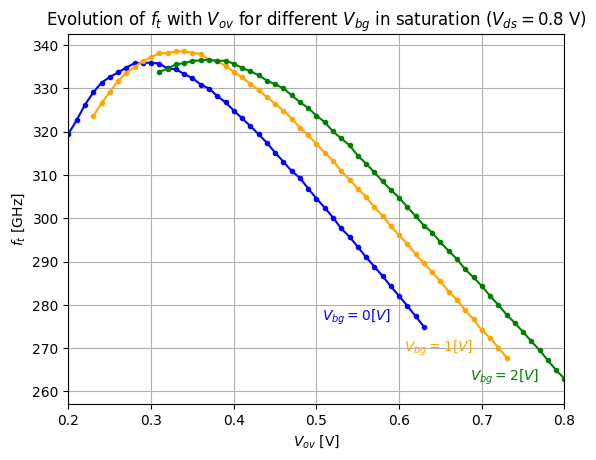

338.6180990272142
365.04278270757897


In [13]:
plt.plot(Vg-Vth0, fmax0*10**-9, ".-",label=None, color='blue')  # Bleu
plt.plot(Vg-Vth1, fmax1*10**-9,".-",label=None, color='orange')  # Orange
plt.plot(Vg-Vth2, fmax2*10**-9,".-", label=None, color='green')  # Vert
plt.text(Vg[-5]-Vth0, fmax0[-1]*10**-9, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='right')  # Bleu
plt.text(Vg[-5]-Vth1, fmax1[-1]*10**-9, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='right')  # Orange
plt.text(Vg[-5]-Vth2, fmax2[-1]*10**-9, "$V_{bg}=2[V]$", color='green', verticalalignment='bottom', horizontalalignment='right')

plt.grid()

plt.title("Evolution of $f_{max}$ with $V_{ov}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")


plt.xlabel("$V_{ov}$ [V]")
plt.ylabel("$f_{max}$ [GHz]")
plt.xlim(0.2,0.8)
plt.savefig("F_max_vov.png")
plt.savefig("F_max_vov.pdf")
plt.show()

plt.plot(Vg-Vth0, ft0*10**-9, ".-",label=None, color='blue')  # Bleu
plt.plot(Vg-Vth1, ft1*10**-9,".-",label=None, color='orange')  # Orange
plt.plot(Vg-Vth2, ft2*10**-9,".-", label=None, color='green')  # Vert
plt.text(Vg[-5]-Vth0, ft0[-1]*10**-9, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='right')  # Bleu
plt.text(Vg[-5]-Vth1, ft1[-1]*10**-9, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='right')  # Orange
plt.text(Vg[-5]-Vth2, ft2[-1]*10**-9, "$V_{bg}=2[V]$", color='green', verticalalignment='bottom', horizontalalignment='right')

plt.grid()

plt.title("Evolution of $f_{t}$ with $V_{ov}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")


plt.xlabel("$V_{ov}$ [V]")
plt.xlim(0.2,0.8)
plt.ylabel("$f_{t}$ [GHz]")
plt.savefig("F_t_vov.png")
plt.savefig("F_t_vov.pdf")
plt.show()

print(max(ft1)*10**-9)
print(max(fmax0)*10**-9)

POURQUOI les courbes se superposent pas  autre effet que modif de vth qui induit un shift? ou mauvaise maniere de calculer vth quand il y a un vbg?

## Plot gm for different Vov

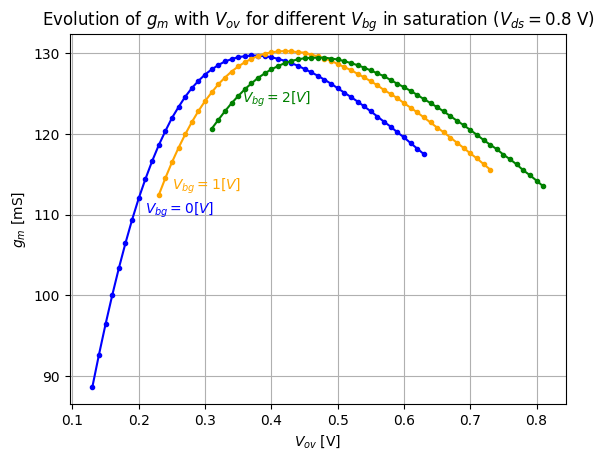

In [29]:
plt.plot(Vg-Vth0, gm0*1000, ".-",label=None, color='blue')  # Bleu
plt.plot(Vg-Vth1, gm1*1000,".-",label=None, color='orange')  # Orange
plt.plot(Vg-Vth2, gm2*1000,".-", label=None, color='green')  # Vert
plt.text(Vg[8]-Vth0, gm0[6]*1000, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='left')  # Bleu
plt.text(Vg[2]-Vth1, gm1[0]*1000, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='left')  # Orange
plt.text(Vg[15]-Vth2, gm2[5]*1000, "$V_{bg}=2[V]$", color='green', verticalalignment='top', horizontalalignment='right')

plt.grid()

plt.title("Evolution of $g_m$ with $V_{ov}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")


plt.xlabel("$V_{ov}$ [V]")
plt.ylabel("$g_m$ [mS]")
plt.savefig("gm.png")
plt.savefig("gm.pdf")
plt.show()

## Plot gds-Vov


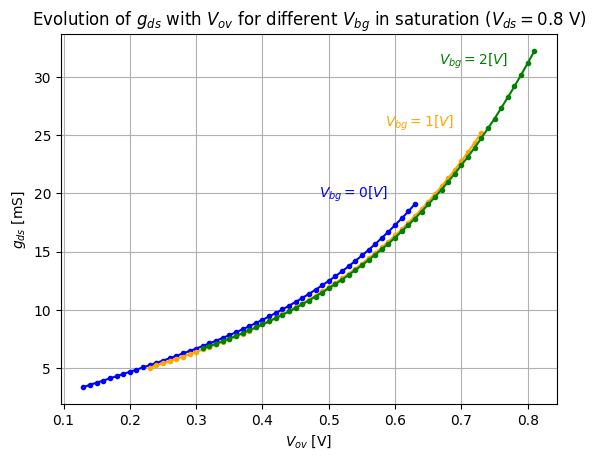

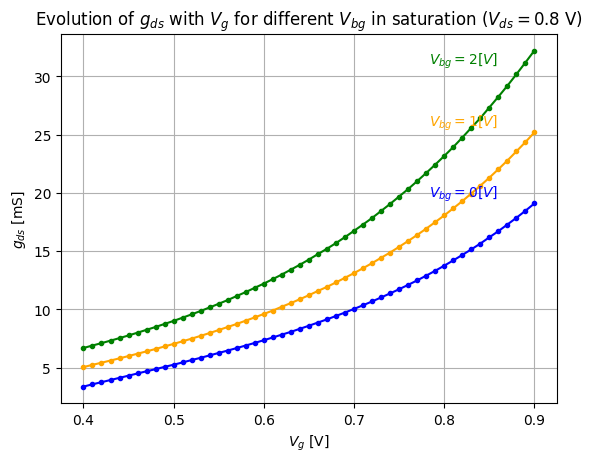

In [30]:
plt.plot(Vg-Vth0, gds0*1000, ".-",label=None, color='blue')  # Bleu
plt.plot(Vg-Vth1, gds1*1000,".-",label=None, color='orange')  # Orange
plt.plot(Vg-Vth2, gds2*1000,".-", label=None, color='green')  # Vert
plt.text(Vg[-5]-Vth0, gds0[-1]*1000, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='right')  # Bleu
plt.text(Vg[-5]-Vth1, gds1[-1]*1000, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='right')  # Orange
plt.text(Vg[-5]-Vth2, gds2[-1]*1000, "$V_{bg}=2[V]$", color='green', verticalalignment='top', horizontalalignment='right')

plt.grid()

plt.title("Evolution of $g_{ds}$ with $V_{ov}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")


plt.xlabel("$V_{ov}$ [V]")
plt.ylabel("$g_{ds}$ [mS]")
plt.savefig("gds_vov.png")
plt.savefig("gds_vov.pdf")
plt.show()
plt.plot(Vg, gds0*1000, ".-",label=None, color='blue')  # Bleu
plt.plot(Vg, gds1*1000,".-",label=None, color='orange')  # Orange
plt.plot(Vg, gds2*1000,".-", label=None, color='green')  # Vert
plt.text(Vg[-5], gds0[-1]*1000, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='right')  # Bleu
plt.text(Vg[-5], gds1[-1]*1000, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='right')  # Orange
plt.text(Vg[-5], gds2[-1]*1000, "$V_{bg}=2[V]$", color='green', verticalalignment='top', horizontalalignment='right')

plt.grid()

plt.title("Evolution of $g_{ds}$ with $V_{g}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")


plt.xlabel("$V_{g}$ [V]")
plt.ylabel("$g_{ds}$ [mS]")
plt.savefig("gds.png")

plt.show()

## Capacitance plot for different Vov

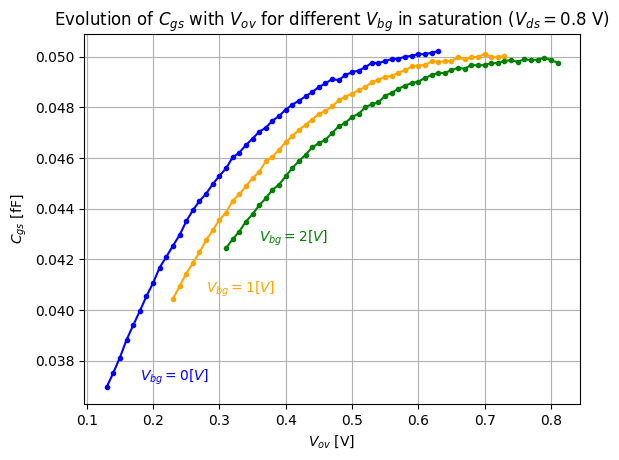

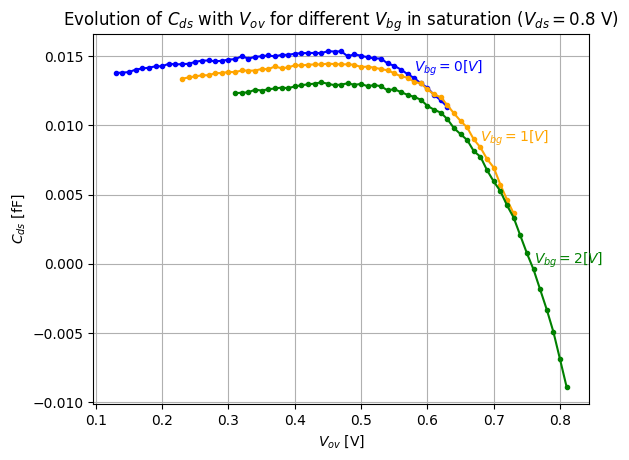

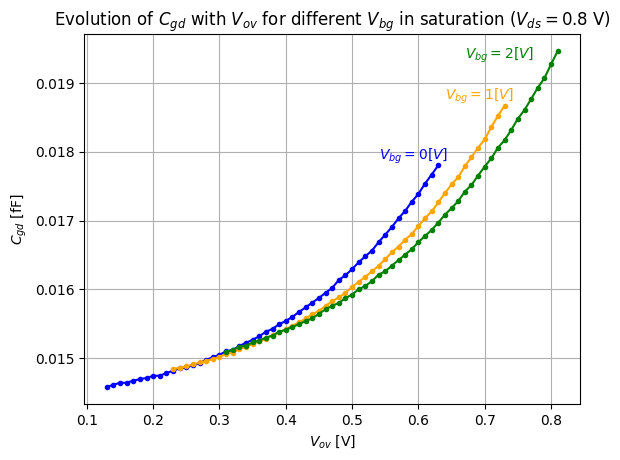

In [31]:
####Cgs
plt.plot(Vg-Vth0, Cgs0*10**12, ".-",label=None, color='blue')  # Bleu
plt.plot(Vg-Vth1, Cgs1*10**12,".-",label=None, color='orange')  # Orange
plt.plot(Vg-Vth2, Cgs2*10**12,".-", label=None, color='green')  # Vert
plt.text(Vg[5]-Vth0, Cgs0[0]*10**12, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='left')  # Bleu
plt.text(Vg[5]-Vth1, Cgs1[0]*10**12, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='left')  # Orange
plt.text(Vg[5]-Vth2, Cgs2[0]*10**12, "$V_{bg}=2[V]$", color='green', verticalalignment='bottom', horizontalalignment='left')

plt.grid()

plt.title("Evolution of $C_{gs}$ with $V_{ov}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")

plt.xlabel("$V_{ov}$ [V]")
plt.ylabel("$C_{gs}$ [fF]")
plt.savefig("Cgs.png")
plt.savefig("Cgs.pdf")
plt.show()

####Cds

plt.plot(Vg-Vth0, Cds0*10**12, ".-",label=None, color='blue')  # Bleu
plt.plot(Vg-Vth1, Cds1*10**12,".-",label=None, color='orange')  # Orange
plt.plot(Vg-Vth2, Cds2*10**12,".-", label=None, color='green')  # Vert
plt.text(Vg[-6]-Vth0, Cds0[-6]*10**12, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='left')  # Bleu
plt.text(Vg[-6]-Vth1, Cds1[-6]*10**12, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='left')  # Orange
plt.text(Vg[-6]-Vth2, Cds2[-6]*10**12, "$V_{bg}=2[V]$", color='green', verticalalignment='bottom', horizontalalignment='left')

plt.grid()

plt.title("Evolution of $C_{ds}$ with $V_{ov}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")

plt.xlabel("$V_{ov}$ [V]")
plt.ylabel("$C_{ds}$ [fF]")
plt.savefig("Cds.png")
plt.savefig("Cds.pdf")
plt.show()

####Cgd

plt.plot(Vg-Vth0, Cgd0*10**12, ".-",label=None, color='blue')  # Bleu
plt.plot(Vg-Vth1, Cgd1*10**12,".-",label=None, color='orange')  # Orange
plt.plot(Vg-Vth2, Cgd2*10**12,".-", label=None, color='green')  # Vert
plt.text(Vg[-10]-Vth0, Cgd0[-1]*10**12, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='left')  # Bleu
plt.text(Vg[-10]-Vth1, Cgd1[-1]*10**12, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='left')  # Orange
plt.text(Vg[-15]-Vth2, Cgd2[-2]*10**12, "$V_{bg}=2[V]$", color='green', verticalalignment='bottom', horizontalalignment='left')

plt.grid()

plt.title("Evolution of $C_{gd}$ with $V_{ov}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")

plt.xlabel("$V_{ov}$ [V]")
plt.ylabel("$C_{gd}$ [fF]")
plt.savefig("Cgd.png")
plt.savefig("Cgd_vov.pdf")

## FOM vs ID

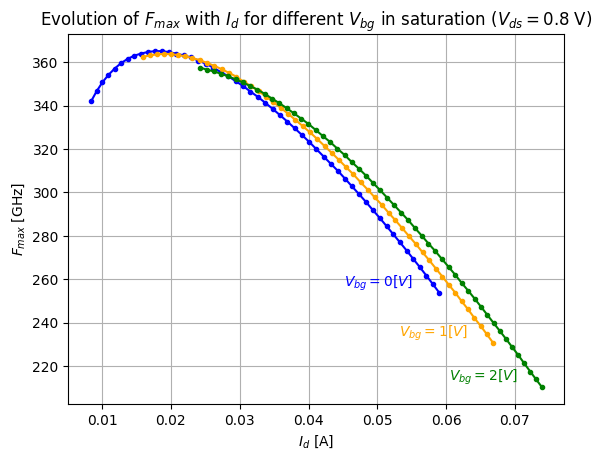

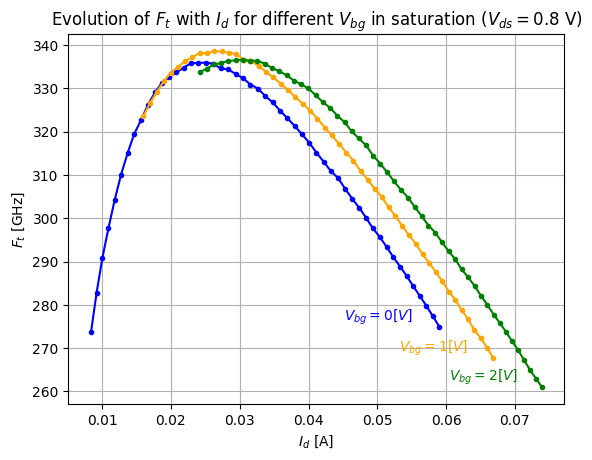

In [32]:


id0_=id0[60:] #Car dans idvg vg commence a -0.2 au lieu de 0.4 avec des pas de 0.01

id1_=id1[60:]
id2_=id2[60:]
plt.plot(id0_, fmax0*10**-9, ".-",label=None, color='blue')  # Bleu
plt.plot(id1_, fmax1*10**-9,".-",label=None, color='orange')  # Orange
plt.plot(id2_, fmax2*10**-9,".-", label=None, color='green')  # Vert
plt.text(id0_[-5], fmax0[-1]*10**-9, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='right')  # Bleu
plt.text(id1_[-5], fmax1[-1]*10**-9, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='right')  # Orange
plt.text(id2_[-5], fmax2[-1]*10**-9, "$V_{bg}=2[V]$", color='green', verticalalignment='bottom', horizontalalignment='right')

plt.grid()

plt.title("Evolution of $F_{max}$ with $I_{d}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")


plt.xlabel("$I_{d}$ [A]")
plt.ylabel("$F_{max}$ [GHz]")

plt.savefig("F_max_id.png")
plt.savefig("F_max_id.pdf")
plt.show()

plt.plot(id0_, ft0*10**-9, ".-",label=None, color='blue')  # Bleu
plt.plot(id1_, ft1*10**-9,".-",label=None, color='orange')  # Orange
plt.plot(id2_, ft2*10**-9,".-", label=None, color='green')  # Vert
plt.text(id0_[-5], ft0[-1]*10**-9, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='right')  # Bleu
plt.text(id1_[-5], ft1[-1]*10**-9, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='right')  # Orange
plt.text(id2_[-5], ft2[-1]*10**-9, "$V_{bg}=2[V]$", color='green', verticalalignment='bottom', horizontalalignment='right')

plt.grid()

plt.title("Evolution of $F_{t}$ with $I_{d}$ for different $V_{bg}$ in saturation ($V_{ds}=0.8$ V)")


plt.xlabel("$I_{d}$ [A]")

plt.ylabel("$F_{t}$ [GHz]")
plt.savefig("F_t_id.png")
plt.show()

Plot of H21(f) to confirm ft 

Ft est: 354.81338923357606 Ghz pour Vbg=0 et Vg=0.0.6


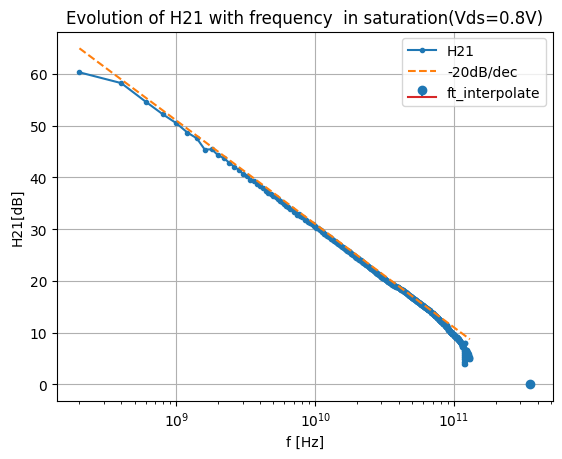

In [33]:
def get_H21(measurements, open, Vth,vg_use_for_ft, Rse=0, Rge=0, Rde=0, Cgse=0, Cdse=0, Cgde=0):
    
    # Retrieving the parameters
    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])
    freq = data[0][:, 0]
    

    # Construction of the series matrix:
    Z_series = np.array([[Rge+Rse, Rse], [Rse, Rde+Rse]])

    Vg = np.zeros(len_data)
    Vd = np.zeros(len_data)

    Z11, Z12, Z21, Z22 = deEmbedding(measurements, open)
    
    # We iterate on each bias point to get Vg and Vd
    for i in range(len_data):
        dummy, info = mdm_reader_index(measurements, i)
        Vg[i] = float(info[1].split()[-1])
        Vd[i] = float(info[0].split()[-1])
    
    Vg_indice=list(Vg).index(vg_use_for_ft)
        
    # Retrieve series matrix from total Z matrix to get DUT Z-matrix
    Z11 -= Z_series[0,0]
    Z12 -= Z_series[0,1]
    Z21 -= Z_series[1,0]
    Z22 -= Z_series[1,1]
    
  
    H11 = Z11-Z12*Z21/Z22
    H12 = Z12/Z22
    H21 = -Z21/Z22
    H22 = 1/Z22
    
    H21=H21[Vg_indice]
    return H21,freq


H210,freq = get_H21(Vbg0, open_measurements, 0.27,0.6, Rse, Rge, Rde, Cgse, Cdse, Cgde)
ft=10**(231/20)
print("Ft est:",ft*10**-9,"Ghz pour Vbg=0 et Vg=0.0.6")
plt.semilogx(freq, 20*np.log10(np.abs(H210)), ".-", label='H21')
plt.semilogx(freq, -20*np.log10(freq)+231, "--", label='-20dB/dec')#256 found to superpose the slope of the straight line
plt.stem(ft,0,label="ft_interpolate")
plt.grid()

plt.title("Evolution of H21 with frequency  in saturation(Vds=0.8V)")
plt.legend()

plt.xlabel("f [Hz]")
plt.ylabel("H21[dB]")
plt.show()



## Gd with frequency (resistance substract effect)

Parameters extracted at Vg=0.6V and Vd=0.8V
Parameters extracted at Vg=0.6V and Vd=0.8V


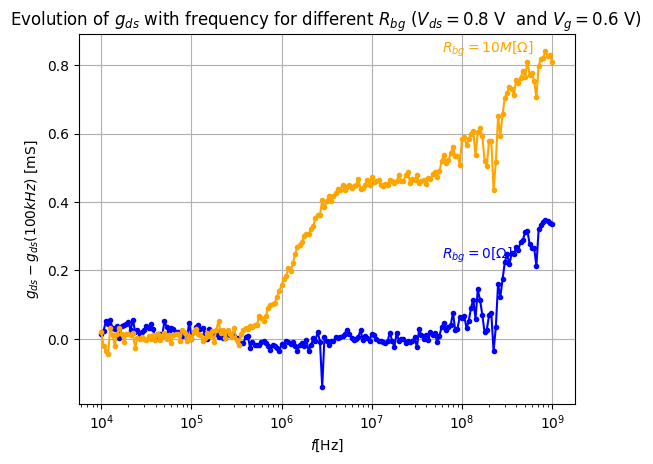

In [34]:
def extract_gd_substract(measurements, open, Vth,Vg_index, Rse=0, Rge=0, Rde=0, Cgse=0, Cdse=0, Cgde=0,plot=False):

    # Retrieving the parameters
    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])
    freq = data[0][:, 0]


    # Construction of the series matrix:
    Z_series = np.array([[Rge+Rse, Rse], [Rse, Rde+Rse]])

    Vg = np.zeros(len_data)
    Vd = np.zeros(len_data)

    Z11, Z12, Z21, Z22 = deEmbedding(measurements, open)

    # We iterate on each bias point to get Vg and Vd
    for i in range(len_data):
        dummy, info = mdm_reader_index(measurements, i)
        Vg[i] = float(info[1].split()[-1])
        Vd[i] = float(info[0].split()[-1])
        
    # Retrieve series matrix from total Z matrix to get DUT Z-matrix
    Z11 -= Z_series[0,0]
    Z12 -= Z_series[0,1]
    Z21 -= Z_series[1,0]
    Z22 -= Z_series[1,1]

    # Get admittance matrix from impedance matrix
    Y11, Y12, Y21, Y22 = [np.zeros_like(Z11) for _ in range(4)]
    for i in range(len_data):
        for j in range(len_col):
            Y = np.linalg.inv(np.array([[Z11[i][j], Z12[i][j]], [Z21[i][j], Z22[i][j]]]))
            Y11[i][j], Y12[i][j], Y21[i][j], Y22[i][j] = np.matrix.flatten(Y)

    # We select a high Vg to be in strong inversion:



    
    Y11_inv = Y11[Vg_index]
    Y12_inv = Y12[Vg_index]
    Y21_inv = Y21[Vg_index]
    Y22_inv = Y22[Vg_index]
    
    gds = np.real(Y22_inv)
   
    gd100k=gds[list(freq).index(100*10**3)]
    print("Parameters extracted at Vg={}V and Vd={}V".format(Vg[Vg_index], Vd[-6]))
    return gds,freq ,gd100k

open_measurements_LF = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf16_OPEN_Spar_LF.mdm"
gds_noR_file = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf16_BGG_vbg_0V_Spar_LF_sat_0p8.mdm"
gds_Rbg_file = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf16_BGF_vbg_0V_Spar_LF_sat_0p8.mdm"
gds_noR,freq,gd100k=extract_gd_substract(gds_noR_file, open_measurements_LF, 0.29, 20,Rse, Rge, Rde, Cgse, Cdse, Cgde)
gds_Rbg,freq,gd_rbg_100k=extract_gd_substract(gds_Rbg_file, open_measurements_LF, 0.29,20,Rse, Rge, Rde, Cgse, Cdse, Cgde)



plt.semilogx(freq, (gds_noR-gd100k)*10**3, ".-",label=None, color='blue')  # Bleu
plt.semilogx(freq, (gds_Rbg-gd_rbg_100k)*10**3, ".-",label=None, color='orange')  # Bleu

plt.text(freq[-50], (gds_noR[-20]-gd100k)*10**3, "$R_{bg}=0[Ω]$", color='blue', verticalalignment='bottom', horizontalalignment='left')  # Bleu
plt.text(freq[-50],(gds_Rbg[-20]-gd100k)*10**3, "$R_{bg}=10M[Ω]$", color='orange', verticalalignment='bottom', horizontalalignment='left')  # Bleu


plt.grid()

plt.title("Evolution of $g_{ds}$ with frequency for different $R_{bg}$ ($V_{ds}=0.8$ V  and $V_{g}=0.6$ V) ")

plt.xlabel("$f$[Hz]")
plt.ylabel("$g_{ds}-g_{ds}(100kHz)$ [mS]")
plt.savefig("gds_freq_substrat.png")

## Gd with frequency for different Vbg

Parameters extracted at Vg=0.6V and Vd=0.8V
Parameters extracted at Vg=0.6V and Vd=0.8V
Parameters extracted at Vg=0.6V and Vd=0.8V


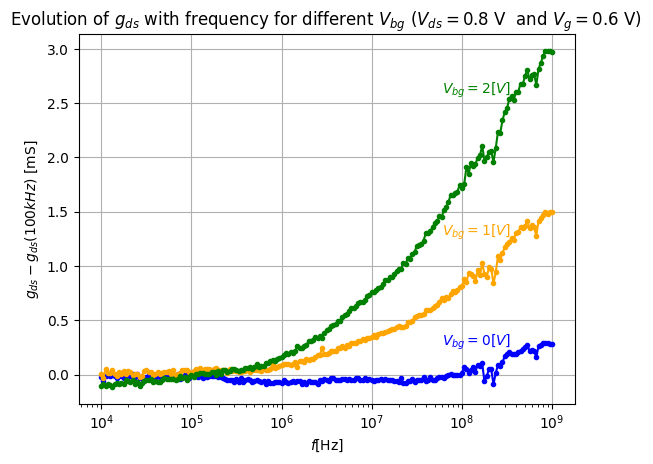

In [35]:
def extract_gd_backgate(measurements, open, Vth,Vg_index, Rse=0, Rge=0, Rde=0, Cgse=0, Cdse=0, Cgde=0,plot=False):

    # Retrieving the parameters
    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])
    freq = data[0][:, 0]


    # Construction of the series matrix:
    Z_series = np.array([[Rge+Rse, Rse], [Rse, Rde+Rse]])

    Vg = np.zeros(len_data)
    Vd = np.zeros(len_data)

    Z11, Z12, Z21, Z22 = deEmbedding(measurements, open)

    # We iterate on each bias point to get Vg and Vd
    for i in range(len_data):
        dummy, info = mdm_reader_index(measurements, i)
        Vg[i] = float(info[1].split()[-1])
        Vd[i] = float(info[0].split()[-1])
        
    # Retrieve series matrix from total Z matrix to get DUT Z-matrix
    Z11 -= Z_series[0,0]
    Z12 -= Z_series[0,1]
    Z21 -= Z_series[1,0]
    Z22 -= Z_series[1,1]

    # Get admittance matrix from impedance matrix
    Y11, Y12, Y21, Y22 = [np.zeros_like(Z11) for _ in range(4)]
    for i in range(len_data):
        for j in range(len_col):
            Y = np.linalg.inv(np.array([[Z11[i][j], Z12[i][j]], [Z21[i][j], Z22[i][j]]]))
            Y11[i][j], Y12[i][j], Y21[i][j], Y22[i][j] = np.matrix.flatten(Y)

    # We select a high Vg to be in strong inversion:



    
    Y11_inv = Y11[Vg_index]
    Y12_inv = Y12[Vg_index]
    Y21_inv = Y21[Vg_index]
    Y22_inv = Y22[Vg_index]
    
    gds = np.real(Y22_inv)
   
    gd100k=gds[list(freq).index(100*10**3)]
    print("Parameters extracted at Vg={}V and Vd={}V".format(Vg[Vg_index], Vd[-6]))
    return gds,freq ,gd100k

open_measurements_LF = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf16_OPEN_Spar_LF.mdm"
gds_0_file = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_Spar_LF_sat_0p8.mdm"
gds_1_file = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_1V_Spar_LF_sat_0p8.mdm"
gds_2_file = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_2V_Spar_LF_sat_0p8.mdm"

gds_0,freq,gd100k0=extract_gd_backgate(gds_0_file, open_measurements_LF, 0.29, 20,Rse, Rge, Rde, Cgse, Cdse, Cgde)
gds_1,freq,gd100k1=extract_gd_backgate(gds_1_file, open_measurements_LF, 0.17,20,Rse, Rge, Rde, Cgse, Cdse, Cgde)
gds_2,freq,gd100k2=extract_gd_backgate(gds_2_file, open_measurements_LF, 0.09,20,Rse, Rge, Rde, Cgse, Cdse, Cgde)


plt.semilogx(freq, (gds_0-gd100k0)*10**3, ".-",label=None, color='blue')  
plt.semilogx(freq, (gds_1-gd100k1)*10**3, ".-",label=None, color='orange')  
plt.semilogx(freq, (gds_2-gd100k2)*10**3, ".-",label=None, color='green')  

plt.text(freq[-50], (gds_0[-20]-gd100k0)*10**3, "$V_{bg}=0[V]$", color='blue', verticalalignment='bottom', horizontalalignment='left')  # Bleu
plt.text(freq[-50],(gds_1[-20]-gd100k1)*10**3, "$V_{bg}=1[V]$", color='orange', verticalalignment='bottom', horizontalalignment='left')  # Bleu
plt.text(freq[-50],(gds_2[-20]-gd100k2)*10**3, "$V_{bg}=2[V]$", color='green', verticalalignment='bottom', horizontalalignment='left')  # Bleu

plt.grid()

plt.title("Evolution of $g_{ds}$ with frequency for different $V_{bg}$ ($V_{ds}=0.8$ V  and $V_{g}=0.6$ V) ")

plt.xlabel("$f$[Hz]")
plt.ylabel("$g_{ds}-g_{ds}(100kHz)$ [mS]")
plt.savefig("gds_freq_bg.png")
plt.savefig("gds_freq_bg.pdf")

In [36]:

def initial_parameters(measurements, open, Vth, Rse=0, Rge=0, Rde=0, Cgse=0, Cdse=0, Cgde=0, plot=False):

    # Retrieving the parameters
    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])
    freq = data[0][:, 0]

    Y11t, Y12t, Y21t, Y22t = [np.zeros((len_data, len_col), dtype='complex') for _ in range(4)] # o for open, t for total (measured here)
    for i in range(len_data):
        Y11t[i], Y12t[i], Y21t[i], Y22t[i] = Y_parameters(measurements, i, plot=False)

    Vg = np.zeros(len_data)
    Vd = np.zeros(len_data)

   

    # We iterate on each bias point to get Vg and Vd
    for i in range(len_data):
        dummy, info = mdm_reader_index(measurements, i)
        Vg[i] = float(info[1].split()[-1])
        Vd[i] = float(info[0].split()[-1])

    freq_index = 59   # 20.2 GHz
    Y11_inv = Y11t[:,freq_index]
    Y12_inv = Y12t[:,freq_index]
    Y21_inv = Y21t[:,freq_index]
    Y22_inv = Y22t[:,freq_index]

    Cgs = np.imag(Y11_inv+Y12_inv) / (2*np.pi*freq[freq_index])
    Cds = np.imag(Y22_inv+Y12_inv) / (2*np.pi*freq[freq_index])
    Cgd = -np.imag(Y12_inv) / (2*np.pi*freq[freq_index])
    gm = np.abs(Y21_inv-Y12_inv)
    gds = np.real(Y22_inv)
    tau = -1*np.angle(Y21_inv-Y12_inv)

    print("Parameters extracted at {:.2f} GHz  and Vd={}V".format(freq[freq_index]*1e-9, Vd[-6]))
    return Cgs, Cds, Cgd, gm, gds, tau,Vg

Cgs_init_0, Cds_init_0, Cgd_init_0, gm_init_0, gds_init_0, tau_init_0,Vg_0 = initial_parameters(Vbg0, open_measurements, 0.29)
Cgs_init_1, Cds_init_1, Cgd_init_1, gm_init_1, gds_init_1, tau_init_1,Vg_1 = initial_parameters(Vbg1, open_measurements, 0.17)
Cgs_init_2, Cds_init_2, Cgd_init_2, gm_init_2, gds_init_2, tau_init_2,Vg_2 = initial_parameters(Vbg2, open_measurements, 0.09)

Parameters extracted at 12.00 GHz  and Vd=0.8V
Parameters extracted at 12.00 GHz  and Vd=0.8V
Parameters extracted at 12.00 GHz  and Vd=0.8V


In [37]:
def open_parameters(measurements, open, Vth, Rse=0, Rge=0, Rde=0, Cgse=0, Cdse=0, Cgde=0, plot=False):

    # Retrieving the parameters
    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])
    freq = data[0][:, 0]

    Vg = np.zeros(len_data)
    Vd = np.zeros(len_data)

    Z11, Z12, Z21, Z22 = deEmbedding(measurements, open)

    # We iterate on each bias point to get Vg and Vd
    for i in range(len_data):
        dummy, info = mdm_reader_index(measurements, i)
        Vg[i] = float(info[1].split()[-1])
        Vd[i] = float(info[0].split()[-1])

    # Get admittance matrix from impedance matrix
    Y11, Y12, Y21, Y22 = [np.zeros_like(Z11) for _ in range(4)]
    for i in range(len_data):
        for j in range(len_col):
            Y = np.linalg.inv(np.array([[Z11[i][j], Z12[i][j]], [Z21[i][j], Z22[i][j]]]))
            Y11[i][j], Y12[i][j], Y21[i][j], Y22[i][j] = np.matrix.flatten(Y)

    # We select a high Vg to be in strong inversion:


    freq_index = 59   
    Y11_inv = Y11[:,freq_index]
    Y12_inv = Y12[:,freq_index]
    Y21_inv = Y21[:,freq_index]
    Y22_inv = Y22[:,freq_index]

    Cgs = np.imag(Y11_inv+Y12_inv) / (2*np.pi*freq[freq_index])
    Cds = np.imag(Y22_inv+Y12_inv) / (2*np.pi*freq[freq_index])
    Cgd = -np.imag(Y12_inv) / (2*np.pi*freq[freq_index])
    gm = np.abs(Y21_inv-Y12_inv)
    gds = np.real(Y22_inv)
    tau = -1*np.angle(Y21_inv-Y12_inv)

    print("Parameters extracted at {:.2f} GHz  and Vd={}V".format(freq[freq_index]*1e-9, Vd[-6]))
    return Cgs, Cds, Cgd, gm, gds, tau,Vg

Cgs_open_0, Cds_open_0, Cgd_open_0, gm_open_0, gds_open_0, tau_open_0,Vg_open_0 = open_parameters(Vbg0, open_measurements, 0.29)
Cgs_open_1, Cds_open_1, Cgd_open_1, gm_open_1, gds_open_1, tau_open_1,Vg_open_1 = open_parameters(Vbg1, open_measurements, 0.17)
Cgs_open_2, Cds_open_2, Cgd_open_2, gm_open_2, gds_open_2, tau_open_2,Vg_open_2 = open_parameters(Vbg2, open_measurements, 0.09)

Parameters extracted at 12.00 GHz  and Vd=0.8V
Parameters extracted at 12.00 GHz  and Vd=0.8V
Parameters extracted at 12.00 GHz  and Vd=0.8V


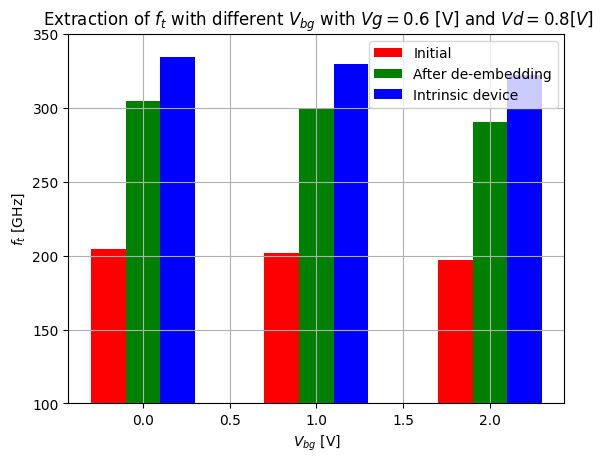

204.3305941493114 334.4233225673361


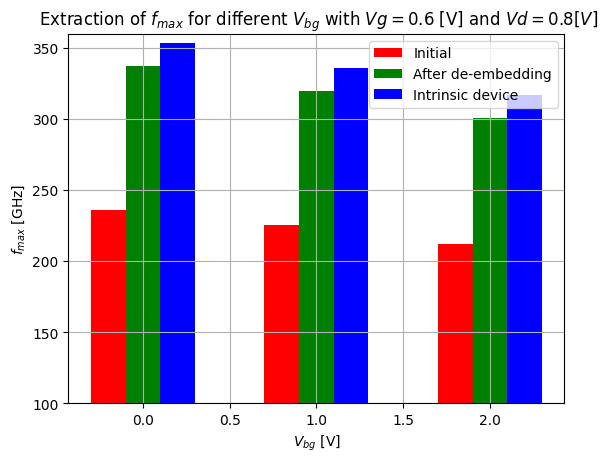

236.2775686652534 353.547846207352


In [38]:
###Plot histogram
vg_use_for_ft=0.6
Vg_indice=list(Vg).index(vg_use_for_ft)
ft_init_0, fmax_init_0 = FoM(Cgs_init_0, Cds_init_0, Cgd_init_0,Rse, Rde, Rge, gm_init_0, gds_init_0)
ft_open_0, fmax_open_0 = FoM(Cgs_open_0, Cds_open_0, Cgd_open_0,Rse, Rde, Rge, gm_open_0, gds_open_0)
ft_init_1, fmax_init_1 = FoM(Cgs_init_1, Cds_init_1, Cgd_init_1, Rse, Rde, Rge, gm_init_1, gds_init_1)
ft_open_1, fmax_open_1= FoM(Cgs_open_1, Cds_open_1, Cgd_open_1, Rse, Rde, Rge, gm_open_1, gds_open_1)
ft_init_2, fmax_init_2 = FoM(Cgs_init_2, Cds_init_2, Cgd_init_2, Rse, Rde, Rge, gm_init_2, gds_init_2)
ft_open_2, fmax_open_2= FoM(Cgs_open_2, Cds_open_2, Cgd_open_2, Rse, Rde, Rge, gm_open_2, gds_open_2)
# Exemple de données
configurations = ['$V_{bg}=0[V]$', '$V_{bg}=1[V]$', '$V_{bg}=2[V]$']
index = np.arange(len(configurations))  # Indices des configurations

ft_initial = [ft_init_0[Vg_indice], ft_init_1[Vg_indice], ft_init_2[Vg_indice]] 
ft_open = [ft_open_0[Vg_indice], ft_open_1[Vg_indice], ft_open_2[Vg_indice]]    
ft_intrinsic = [ft0[Vg_indice], ft1[Vg_indice], ft2[Vg_indice]] 


index = np.arange(len(configurations))  
bar_width=0.2
# Création de l'histogramme
plt.bar(index - bar_width, np.array(ft_initial)*10**-9, bar_width, color='r', label='Initial')
plt.bar(index, np.array(ft_open)*10**-9, bar_width, color='g', label='After de-embedding')
plt.bar(index + bar_width, np.array(ft_intrinsic)*10**-9, bar_width, color='b', label='Intrinsic device')

# Ajout de légendes et de titres
plt.xlabel('$V_{bg}$ [V]')
plt.ylabel('$f_t$ [GHz]')
plt.title(' Extraction of $f_t$ with different $V_{bg}$ with $Vg=0.6$ [V] and $Vd=0.8 [V]$')
plt.legend()
plt.grid()
plt.ylim(100,350)
plt.savefig("f_t_hist.png")
plt.savefig("f_t_hist.pdf")
# Affichage de l'histogramme
plt.show()


fmax_initial = [fmax_init_0[Vg_indice], fmax_init_1[Vg_indice], fmax_init_2[Vg_indice]] 
fmax_open = [fmax_open_0[Vg_indice], fmax_open_1[Vg_indice], fmax_open_2[Vg_indice]]    
fmax_intrinsic = [fmax0[Vg_indice], fmax1[Vg_indice], fmax2[Vg_indice]] 

print(ft_init_0[Vg_indice]*10**-9,ft0[Vg_indice]*10**-9)
index = np.arange(len(configurations))  
bar_width=0.2
# Création de l'histogramme
plt.bar(index - bar_width, np.array(fmax_initial)*10**-9, bar_width, color='r', label='Initial')
plt.bar(index, np.array(fmax_open)*10**-9, bar_width, color='g', label='After de-embedding')
plt.bar(index + bar_width, np.array(fmax_intrinsic)*10**-9, bar_width, color='b', label='Intrinsic device')

# Ajout de légendes et de titres
plt.xlabel('$V_{bg}$ [V]')
plt.ylabel('$f_{max}$ [GHz]')
plt.title(' Extraction of $f_{max}$ for different $V_{bg}$ with $Vg=0.6$ [V] and $Vd=0.8 [V]$')
plt.legend()
plt.grid()
plt.ylim(100,360)
plt.savefig("f_max_hist.png")
plt.savefig("f_max_hist.pdf")
# Affichage de l'histogramme
plt.show()
print(fmax_init_0[Vg_indice]*10**-9,fmax0[Vg_indice]*10**-9)



Peut etre faire pour le Vg ou ft est max pour chaque Vbg plutot que le meme Vg?